# Predicting Hourly Bike Rentals
Using a few different machine learning models, we will predict the number of bike rentals for a given hour. The efficacy of each model will be measured using Mean Squared Error. 
  
The dataset can be downloaded from [The University of California, Irvine's site](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). Hadi Fanaee-T at the University of Porto compiled this data into a CSV file.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

df = pd.read_csv('bike_rental_hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


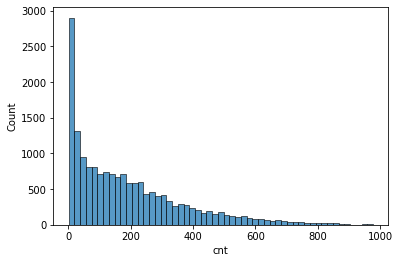

In [2]:
sns.histplot(df['cnt']);

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

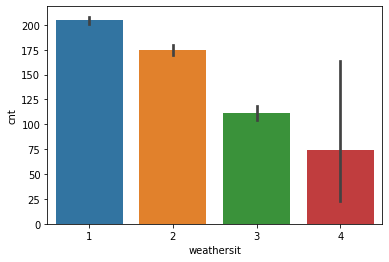

In [3]:
sns.barplot(y='cnt', x='weathersit', data=df)

In [4]:
def assign_time_labels(t):
    '''
    Engineers daypart feature based on time of day intervals.
    For pd.Series.apply()
    args :
        t : (int) the hour of the day 0-23
    returns :
        each row of data
    '''
    if t > 20 or t < 5:
        return 4
    elif 5 <= t <= 11:
        return 1
    elif 11 < t <= 16:
        return 2
    else:
        return 3
    
df['daypart'] = df['hr'].apply(assign_time_labels) 

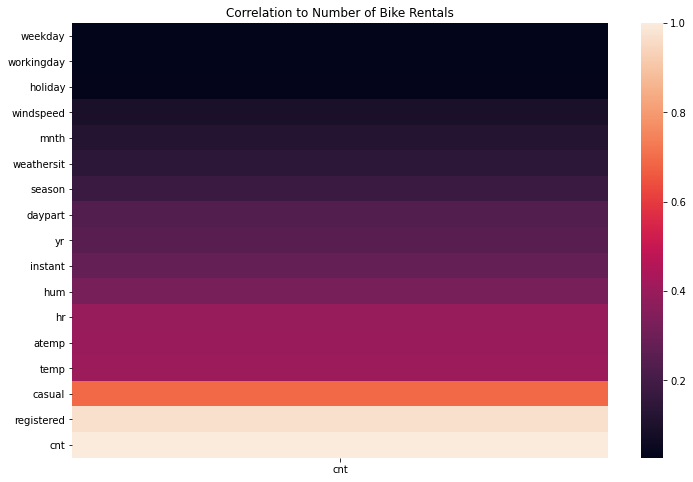

In [5]:
corrs = abs(df.corr()[['cnt']])
corrs = corrs.sort_values('cnt')
plt.figure(figsize=(12,8))
sns.heatmap(corrs)
plt.title('Correlation to Number of Bike Rentals');

In [6]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score, explained_variance_score
from sklearn.model_selection import train_test_split, cross_val_score

import numpy as np

In [7]:
feature_cols = ['season', 'yr', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'windspeed', 'daypart']

In [8]:
X = df[feature_cols]
y = df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

In [9]:
class MLpipeline():
    def __init__(self, X, y, model, auto=False, *args, **kwargs):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.33, random_state=5)
        self.model = model(**kwargs)
        self.results = {}
        if auto:
            self.train(auto_test=True)
    
    def test(self):
        
        predicts = self.model.predict(self.X_test)
        self.results['model'] = self.model
        self.results['model_score'] = self.model.score(self.X_train, self.y_train)
        self.results['cross_val_score'] = self.cv_scores()
        self.results['predictions'] = predicts
        self.results['mse'] = mean_squared_error(self.y_test, predicts)
        self.results['rmse'] = np.sqrt(mean_squared_error(self.y_test, predicts))
        self.results['explained_var_score'] = explained_variance_score(self.y_test, predicts)
        
        return self.results
    
    def print_results(self):
        for k, v in self.results.items():
            if k != 'predictions':
                print('|', k + ':', v)
                print('|' + '-'*45)
        
    def train(self, auto_test=False):
        if auto_test:
            self.model.fit(self.X_train, self.y_train)
            self.test()
        else:
            return self.model.fit(self.X_train, self.y_train)
        
    def cv_scores(self, *args, **kwargs):
        cv_score = cross_val_score(self.model, self.X, self.y, **kwargs)
        return cv_score.mean()

### Linear Regression

In [10]:
linear_regression = MLpipeline(X, y, LinearRegression, True)

In [11]:
linear_regression.print_results()

| model: LinearRegression()
|---------------------------------------------
| model_score: 0.4322033772120272
|---------------------------------------------
| cross_val_score: 0.2866478215721616
|---------------------------------------------
| mse: 19555.848866498058
|---------------------------------------------
| rmse: 139.8422284808779
|---------------------------------------------
| explained_var_score: 0.42520728571893196
|---------------------------------------------


### Decision Tree Regression

In [12]:
sample_leaf = 12
decision_tree = MLpipeline(X, y, DecisionTreeRegressor, auto=True,
                           min_samples_leaf=sample_leaf, random_state=5)

In [13]:
decision_tree.print_results()

| model: DecisionTreeRegressor(min_samples_leaf=12, random_state=5)
|---------------------------------------------
| model_score: 0.9243580250021712
|---------------------------------------------
| cross_val_score: 0.6738011667509234
|---------------------------------------------
| mse: 3177.1268773024817
|---------------------------------------------
| rmse: 56.36600817250129
|---------------------------------------------
| explained_var_score: 0.9066209081112329
|---------------------------------------------


### Random Forest Regression

In [14]:
n_est = 100
random_forest = MLpipeline(X, y, RandomForestRegressor, auto=True, n_estimators=n_est)

In [15]:
random_forest.print_results()

| model: RandomForestRegressor()
|---------------------------------------------
| model_score: 0.990643697861214
|---------------------------------------------
| cross_val_score: 0.8055908291588063
|---------------------------------------------
| mse: 2043.6620319609146
|---------------------------------------------
| rmse: 45.206880360857845
|---------------------------------------------
| explained_var_score: 0.9399717543080401
|---------------------------------------------


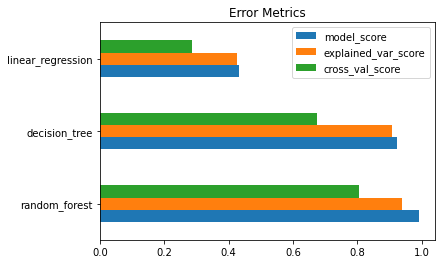

In [17]:
labels = ['random_forest', 'decision_tree', 'linear_regression']
vals = [random_forest.results, decision_tree.results, linear_regression.results]
metrics = ['model_score', 'explained_var_score', 'cross_val_score']
value_list = []
label_dict = {i: None for i in labels}
for v, l in zip(vals, labels):
    value_list = []
    for m in metrics:
        value_list.append(v[m])
    label_dict[l] = value_list

d = pd.DataFrame(label_dict).transpose()
d = d.rename(columns={i: n for i, n in enumerate(metrics)})
d.plot.barh(title='Error Metrics');

## Bike Rental Predictions Results Recap
The Random Forest and Decision Tree Models drastically outperformed the Linear Regression Model.  
The Random Forest was a little more accurate than the Decision Tree--and there was less overfitting.  